In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow as tf

from itertools import product

from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
class_name = 'Occupancy'
df_training = pd.read_csv('training.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df_test = pd.read_csv('test.csv', skipinitialspace=True, na_values='?', keep_default_na=True)

weekend_train = df_training['weekend']
weekend_test = df_test['weekend']
columns2remove = ['date', 'Unnamed: 0', 'cumulative_hour', 'cumulative_minute', 'day', 'weekend', 'day_minute', 'minute', 'hour']
df_training.drop(columns2remove, inplace=True, axis=1)
df_test.drop(columns2remove, inplace=True, axis=1)
df_training.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


In [3]:
attributes = [col for col in df_training.columns if col != class_name]

X_train = df_training[attributes].values
y_train = df_training[class_name]

X_test = df_test[attributes].values
y_test = df_test[class_name]

#normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create a validation set for deep neural netwoeks
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)

X_train.shape

(12952, 5)

In [ ]:
#Per la consegna finale cambiare il numero delle epoche e altri parametri sui risultati migliori ottenuti qua
ACT = ['relu', 'tanh', 'linear', 'softsign', 'softplus']
    
conta_iterazione = 0
summary = []
model_list = []

call = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

init = tf.keras.initializers.RandomUniform(seed=42)
opt = keras.optimizers.Adam(learning_rate = 0.01)

for funzioni in product(ACT, repeat = 4): #Sono 120 permutazioni
        
    conta_iterazione += 1
        
    n_feature = X_train.shape[1]
    model = Sequential() 
        

    model.add(Dense(6, input_shape = (5,), activation =funzioni[0] , kernel_initializer=init, bias_initializer = 'zeros'))
    model.add(Dense(9, activation  = funzioni[1], kernel_initializer=init, bias_initializer = 'zeros'))
    model.add(Dense(12, activation = funzioni[2], kernel_initializer=init, bias_initializer = 'zeros'))
    model.add(Dense(3, activation  = funzioni[3], kernel_initializer=init, bias_initializer = 'zeros'))
    model.add(Dense(1, activation  = 'sigmoid', kernel_initializer=init, bias_initializer = 'zeros'))
    
    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=30, batch_size=100, use_multiprocessing = True,
                    callbacks = [call], validation_data=(X_val, y_val), class_weight = {0: 0.85, 1: 0.15}).history
    test_loss, test_acc = model.evaluate(X_test, y_test)
    y_pred = model.predict_classes(X_test).astype(int)

    print('============= MODEL {} ==================='.format(conta_iterazione))
    print('Accuracy Model {} {}'.format(conta_iterazione, accuracy_score(y_test, y_pred)))
    print('F1-score Model {} {}'.format(conta_iterazione, f1_score(y_test, y_pred, average=None)))
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
        
    model_list.append(model)
    summary.append({'iterazione' : conta_iterazione, 
                'params' : [funzioni, opt],
                'test_accuracy' : accuracy_score(y_test, y_pred),
                'f1-score [0]' : f1_score(y_test, y_pred, average=None)[0],
                'f1-score [1]' : f1_score(y_test, y_pred, average=None)[1],
                'precision [1]' : report['1']['precision'],
                'recall [1]' : report['1']['recall']})   
    
    #plt.plot(history['loss'], label = [funzioni, ottimizzatore])
    #plt.xlabel('Epochs')
    #plt.ylabel('Cross-Entropy')
    #plt.legend()
    #plt.show()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 1s 74us/step - loss: 0.3269 - accuracy: 0.7448 - val_loss: 0.5670 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 1s 47us/step - loss: 0.1969 - accuracy: 0.7462 - val_loss: 0.6085 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 0s 38us/step - loss: 0.1620 - accuracy: 0.7462 - val_loss: 0.6630 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 1s 40us/step - loss: 0.1514 - accuracy: 0.7462 - val_loss: 0.7044 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 1s 41us/ste

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 1s 54us/step - loss: 0.1631 - accuracy: 0.7462 - val_loss: 0.7622 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 1s 45us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7904 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 1s 42us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7725 - val_accuracy: 0.7458
Epoch 4/30
6168/6168 [==============================] - 0s 56us/step
============= MODEL 2 ===================
Accuracy Model 2 0.8221465629053177
F1-score Model 2 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 1s 65us/step - loss: 0.1623 - accuracy: 0.7463 - val_loss: 0.7802 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 1s 41us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7670 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 1s 44us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7844 - val_accuracy: 0.7458
Epoch 4/30
6168/6168 [==============================] - 0s 51us/step
============= MODEL 7 ===================
Accuracy Model 7 0.8221465629053177
F1-score Model 7 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6

12952/12952 [==============================] - 1s 45us/step - loss: 0.0269 - accuracy: 0.9866 - val_loss: 0.1077 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 1s 44us/step - loss: 0.0261 - accuracy: 0.9868 - val_loss: 0.0991 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 1s 44us/step - loss: 0.0256 - accuracy: 0.9859 - val_loss: 0.0911 - val_accuracy: 0.9882
Epoch 6/30
12952/12952 [==============================] - 1s 45us/step - loss: 0.0251 - accuracy: 0.9853 - val_loss: 0.0875 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 1s 44us/step - loss: 0.0251 - accuracy: 0.9849 - val_loss: 0.0886 - val_accuracy: 0.9861
Epoch 8/30
12952/12952 [==============================] - 1s 44us/step - loss: 0.0251 - accuracy: 0.9850 - val_loss: 0.0833 - val_accuracy: 0.9875
Epoch 9/30
12952/12952 [==============================] - 1s 44us/step - loss: 0.0250 - accuracy: 0.9855 - val_loss: 0.0867 - val

6168/6168 [==============================] - 0s 60us/step
============= MODEL 23 ===================
Accuracy Model 23 0.9802204928664072
F1-score Model 23 [0.98782678 0.94727744]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.90      1.00      0.95      1097

    accuracy                           0.98      6168
   macro avg       0.95      0.99      0.97      6168
weighted avg       0.98      0.98      0.98      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 1s 97us/step - loss: 0.1144 - accuracy: 0.8149 - val_loss: 0.0794 - val_accuracy: 0.9875
Epoch 2/30
12952/12952 [==============================] - 1s 51us/step - loss: 0.0282 - accuracy: 0.9870 - val_loss: 0.0917 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 1s 48us/step - loss: 0.0270 - accuracy: 0.9870 - val_loss: 0.0780 - val_accuracy: 0.9875
Epo

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 1s 104us/step - loss: 0.0945 - accuracy: 0.8875 - val_loss: 0.0998 - val_accuracy: 0.9819
Epoch 2/30
12952/12952 [==============================] - 1s 52us/step - loss: 0.0292 - accuracy: 0.9863 - val_loss: 0.0936 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 1s 49us/step - loss: 0.0282 - accuracy: 0.9853 - val_loss: 0.1536 - val_accuracy: 0.9743
Epoch 4/30
12952/12952 [==============================] - 1s 49us/step - loss: 0.0313 - accuracy: 0.9822 - val_loss: 0.0810 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 1s 48us/step - loss: 0.0267 - accuracy: 0.9870 - val_loss: 0.1110 - val_accuracy: 0.9882
Epoch 6/30
12952/12952 [==============================] - 1s 49us/step - loss: 0.0266 - accuracy: 0.9870 - val_loss: 0.0901 - val_accuracy: 0.9882
Epoch 7/30
12952/12952 [==============================] - 1s 48us/st

Epoch 7/30
12952/12952 [==============================] - 1s 55us/step - loss: 0.0252 - accuracy: 0.9849 - val_loss: 0.0955 - val_accuracy: 0.9819
Epoch 8/30
12952/12952 [==============================] - 1s 55us/step - loss: 0.0251 - accuracy: 0.9854 - val_loss: 0.0796 - val_accuracy: 0.9819
Epoch 9/30
12952/12952 [==============================] - 1s 55us/step - loss: 0.0256 - accuracy: 0.9838 - val_loss: 0.0790 - val_accuracy: 0.9875
Epoch 10/30
12952/12952 [==============================] - 1s 55us/step - loss: 0.0250 - accuracy: 0.9845 - val_loss: 0.0784 - val_accuracy: 0.9861
Epoch 11/30
12952/12952 [==============================] - 1s 54us/step - loss: 0.0255 - accuracy: 0.9842 - val_loss: 0.0846 - val_accuracy: 0.9819
Epoch 12/30
12952/12952 [==============================] - 1s 54us/step - loss: 0.0249 - accuracy: 0.9840 - val_loss: 0.1019 - val_accuracy: 0.9826
Epoch 13/30
12952/12952 [==============================] - 1s 56us/step - loss: 0.0250 - accuracy: 0.9842 - val_los

Epoch 3/30
12952/12952 [==============================] - 1s 60us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7913 - val_accuracy: 0.7458
Epoch 4/30
6168/6168 [==============================] - 1s 96us/step
============= MODEL 47 ===================
Accuracy Model 47 0.8221465629053177
F1-score Model 47 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 2s 146us/step - loss: 0.0599 - accuracy: 0.8770 - val_loss: 0.0887 - val_accuracy: 0.9861
Epoch 2/30
12952/12952 [==============================] - 1s 68us/step - loss: 0.0262 - accuracy: 0.9869 - val_loss: 0.0912 - val_accuracy

Epoch 5/30
12952/12952 [==============================] - 1s 61us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7594 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 1s 60us/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.7871 - val_accuracy: 0.7458
Epoch 7/30
6168/6168 [==============================] - 1s 97us/step
============= MODEL 52 ===================
Accuracy Model 52 0.8221465629053177
F1-score Model 52 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 2s 155us/step - loss: 0.0594 - accuracy: 0.9220 - val_loss: 0.1103 - val_accuracy

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 3s 206us/step - loss: 0.0589 - accuracy: 0.9365 - val_loss: 0.1387 - val_accuracy: 0.9708
Epoch 2/30
12952/12952 [==============================] - 1s 75us/step - loss: 0.0272 - accuracy: 0.9833 - val_loss: 0.0718 - val_accuracy: 0.9847
Epoch 3/30
12952/12952 [==============================] - 1s 82us/step - loss: 0.0261 - accuracy: 0.9829 - val_loss: 0.0708 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 1s 81us/step - loss: 0.0255 - accuracy: 0.9857 - val_loss: 0.0855 - val_accuracy: 0.9854
Epoch 5/30
12952/12952 [==============================] - 1s 86us/step - loss: 0.0250 - accuracy: 0.9849 - val_loss: 0.0640 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 1s 82us/step - loss: 0.0247 - accuracy: 0.9845 - val_loss: 0.0824 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 1s 80us/st

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 3s 239us/step - loss: 0.1896 - accuracy: 0.7442 - val_loss: 0.7312 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 1s 82us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7667 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 1s 88us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7720 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 1s 90us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7737 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 1s 90us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7746 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 1s 91us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7748 - val_accuracy: 0.7458
Epoch 7/30
12952/12952 [==============================] - 1s 86us/st

12952/12952 [==============================] - 5s 392us/step - loss: 0.0823 - accuracy: 0.7436 - val_loss: 0.1919 - val_accuracy: 0.9778
Epoch 2/30
12952/12952 [==============================] - 2s 133us/step - loss: 0.0306 - accuracy: 0.9866 - val_loss: 0.1228 - val_accuracy: 0.9875
Epoch 3/30
12952/12952 [==============================] - 2s 129us/step - loss: 0.0273 - accuracy: 0.9869 - val_loss: 0.1044 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 2s 133us/step - loss: 0.0265 - accuracy: 0.9869 - val_loss: 0.0939 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 2s 133us/step - loss: 0.0261 - accuracy: 0.9869 - val_loss: 0.0921 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 2s 133us/step - loss: 0.0262 - accuracy: 0.9870 - val_loss: 0.0909 - val_accuracy: 0.9868
Epoch 7/30
6168/6168 [==============================] - 1s 238us/step
============= MODEL 75 ===================
Accuracy M

12952/12952 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.98 - 1s 87us/step - loss: 0.0259 - accuracy: 0.9826 - val_loss: 0.0877 - val_accuracy: 0.9868
Epoch 8/30
12952/12952 [==============================] - 1s 80us/step - loss: 0.0255 - accuracy: 0.9866 - val_loss: 0.0986 - val_accuracy: 0.9757
Epoch 9/30
12952/12952 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.98 - 1s 80us/step - loss: 0.0255 - accuracy: 0.9836 - val_loss: 0.0832 - val_accuracy: 0.9868
Epoch 10/30
12952/12952 [==============================] - 1s 80us/step - loss: 0.0254 - accuracy: 0.9842 - val_loss: 0.0743 - val_accuracy: 0.9868
Epoch 11/30
12952/12952 [==============================] - 1s 85us/step - loss: 0.0251 - accuracy: 0.9837 - val_loss: 0.0939 - val_accuracy: 0.9840
Epoch 12/30
12952/12952 [==============================] - 1s 88us/step - loss: 0.0250 - accuracy: 0.9849 - val_loss: 0.0710 - val_accuracy: 0.9868
Epoch 13/30
12952/12952 [=================

6168/6168 [==============================] - 1s 212us/step
============= MODEL 87 ===================
Accuracy Model 87 0.8221465629053177
F1-score Model 87 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 4s 275us/step - loss: 0.0553 - accuracy: 0.9429 - val_loss: 0.0890 - val_accuracy: 0.9861
Epoch 2/30
12952/12952 [==============================] - 1s 93us/step - loss: 0.0262 - accuracy: 0.9858 - val_loss: 0.0851 - val_accuracy: 0.9861
Epoch 3/30
12952/12952 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.98 - 1s 93us/step - loss: 0.0264 - accuracy: 0.9848 -

Epoch 1/30
12952/12952 [==============================] - 4s 284us/step - loss: 0.1862 - accuracy: 0.7449 - val_loss: 0.7392 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.74 - 1s 91us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7651 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 1s 89us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7734 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 1s 91us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7723 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 1s 90us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7749 - val_accuracy: 0.74580.147
Epoch 6/30
6168/6168 [==============================] - 1s 168us/step
============= MODEL 91 ===================
Accuracy Model 91 0.8221465629053177
F1-score Model 91 [0.90239345 0.        ]
              precision  

Epoch 2/30
12952/12952 [==============================] - 1s 96us/step - loss: 0.0313 - accuracy: 0.9853 - val_loss: 0.1289 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 1s 108us/step - loss: 0.0274 - accuracy: 0.9866 - val_loss: 0.1068 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 1s 96us/step - loss: 0.0262 - accuracy: 0.9870 - val_loss: 0.0936 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 1s 106us/step - loss: 0.0260 - accuracy: 0.9872 - val_loss: 0.0895 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 1s 104us/step - loss: 0.0258 - accuracy: 0.9872 - val_loss: 0.0874 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 1s 105us/step - loss: 0.0259 - accuracy: 0.9871 - val_loss: 0.0856 - val_accuracy: 0.9875
Epoch 8/30
12952/12952 [==============================] - 1s 112us/step - loss: 0.0258 - accuracy: 0.9872 - val_lo

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 5s 352us/step - loss: 0.0921 - accuracy: 0.8650 - val_loss: 0.0771 - val_accuracy: 0.9875
Epoch 2/30
12952/12952 [==============================] - 1s 109us/step - loss: 0.0282 - accuracy: 0.9866 - val_loss: 0.0828 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 1s 105us/step - loss: 0.0272 - accuracy: 0.9867 - val_loss: 0.0833 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 1s 100us/step - loss: 0.0266 - accuracy: 0.9870 - val_loss: 0.0860 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 1s 102us/step - loss: 0.0265 - accuracy: 0.9871 - val_loss: 0.0791 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 1s 107us/step - loss: 0.0265 - accuracy: 0.9871 - val_loss: 0.0858 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 1s 93

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 6s 431us/step - loss: 0.1608 - accuracy: 0.7462 - val_loss: 0.7471 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 2s 118us/step - loss: 0.1468 - accuracy: 0.7462 - val_loss: 0.7560 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 2s 117us/step - loss: 0.1467 - accuracy: 0.7462 - val_loss: 0.8030 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 2s 118us/step - loss: 0.1467 - accuracy: 0.7462 - val_loss: 0.8141 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 1s 115us/step - loss: 0.1466 - accuracy: 0.7462 - val_loss: 0.7652 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 2s 125us/step - loss: 0.1466 - accuracy: 0.7462 - val_loss: 0.7762 - val_accuracy: 0.7458
Epoch 7/30
12952/12952 [==============================] - 2s 12

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 6s 483us/step - loss: 0.0603 - accuracy: 0.8762 - val_loss: 0.1238 - val_accuracy: 0.9819
Epoch 2/30
12952/12952 [==============================] - 2s 123us/step - loss: 0.0255 - accuracy: 0.9847 - val_loss: 0.0709 - val_accuracy: 0.9861
Epoch 3/30
12952/12952 [==============================] - 2s 130us/step - loss: 0.0254 - accuracy: 0.9842 - val_loss: 0.0870 - val_accuracy: 0.9833
Epoch 4/30
12952/12952 [==============================] - 2s 128us/step - loss: 0.0255 - accuracy: 0.9850 - val_loss: 0.0805 - val_accuracy: 0.9840
Epoch 5/30
12952/12952 [==============================] - 2s 127us/step - loss: 0.0252 - accuracy: 0.9846 - val_loss: 0.0874 - val_accuracy: 0.9854
Epoch 6/30
12952/12952 [==============================] - 2s 124us/step - loss: 0.0251 - accuracy: 0.9854 - val_loss: 0.0833 - val_accuracy: 0.9847
Epoch 7/30
12952/12952 [==============================] - 2s 12

12952/12952 [==============================] - 1s 111us/step - loss: 0.0258 - accuracy: 0.9872 - val_loss: 0.0853 - val_accuracy: 0.9875
Epoch 8/30
12952/12952 [==============================] - 1s 111us/step - loss: 0.0258 - accuracy: 0.9873 - val_loss: 0.0861 - val_accuracy: 0.9875
Epoch 9/30
12952/12952 [==============================] - 1s 112us/step - loss: 0.0257 - accuracy: 0.9872 - val_loss: 0.0849 - val_accuracy: 0.9875
Epoch 10/30
12952/12952 [==============================] - 1s 112us/step - loss: 0.0258 - accuracy: 0.9873 - val_loss: 0.0865 - val_accuracy: 0.9875
Epoch 11/30
6168/6168 [==============================] - 1s 226us/step
============= MODEL 120 ===================
Accuracy Model 120 0.9810311284046692
F1-score Model 120 [0.9883315  0.94932871]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.90      1.00      0.95      1097

    accuracy                           0.98      6168
   m

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 6s 474us/step - loss: 0.0833 - accuracy: 0.8887 - val_loss: 0.1508 - val_accuracy: 0.9694
Epoch 2/30
12952/12952 [==============================] - 1s 115us/step - loss: 0.0335 - accuracy: 0.9805 - val_loss: 0.0875 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 1s 113us/step - loss: 0.0270 - accuracy: 0.9869 - val_loss: 0.0826 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 1s 111us/step - loss: 0.0268 - accuracy: 0.9868 - val_loss: 0.0814 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 1s 114us/step - loss: 0.0267 - accuracy: 0.9868 - val_loss: 0.0856 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 1s 114us/step - loss: 0.0267 - accuracy: 0.9868 - val_loss: 0.0827 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 1s 11

12952/12952 [==============================] - 2s 119us/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.7683 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 2s 122us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7716 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 2s 116us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7744 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 2s 118us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7731 - val_accuracy: 0.7458
Epoch 6/30
6168/6168 [==============================] - 2s 248us/step
============= MODEL 136 ===================
Accuracy Model 136 0.8221465629053177
F1-score Model 136 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   mac

Epoch 7/30
12952/12952 [==============================] - 2s 122us/step - loss: 0.0260 - accuracy: 0.9850 - val_loss: 0.0821 - val_accuracy: 0.9854
Epoch 8/30
12952/12952 [==============================] - 2s 119us/step - loss: 0.0262 - accuracy: 0.9844 - val_loss: 0.0674 - val_accuracy: 0.9875
Epoch 9/30
12952/12952 [==============================] - 2s 122us/step - loss: 0.0254 - accuracy: 0.9858 - val_loss: 0.0944 - val_accuracy: 0.9812
Epoch 10/30
12952/12952 [==============================] - 2s 120us/step - loss: 0.0261 - accuracy: 0.9844 - val_loss: 0.0961 - val_accuracy: 0.9806
Epoch 11/30
6168/6168 [==============================] - 2s 254us/step
============= MODEL 139 ===================
Accuracy Model 139 0.9917315175097277
F1-score Model 139 [0.99494699 0.97726259]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.96      1.00      0.98      1097

    accuracy                           0.99    

12952/12952 [==============================] - 8s 580us/step - loss: 0.1883 - accuracy: 0.7425 - val_loss: 0.7322 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 2s 125us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7655 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 2s 123us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7729 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 2s 123us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7720 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 2s 124us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7713 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 2s 124us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7735 - val_accuracy: 0.7458
Epoch 7/30
6168/6168 [==============================] - 2s 270us/step
============= MODEL 146 ===================
Accuracy 

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 8s 629us/step - loss: 0.1872 - accuracy: 0.7418 - val_loss: 0.7361 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 2s 127us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7663 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 2s 127us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7713 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 2s 123us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7736 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 2s 125us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7741 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 2s 127us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7722 - val_accuracy: 0.7458
Epoch 7/30
12952/12952 [==============================] - 2s 12

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 9s 696us/step - loss: 0.0640 - accuracy: 0.7519 - val_loss: 0.2150 - val_accuracy: 0.9819
Epoch 2/30
12952/12952 [==============================] - 2s 133us/step - loss: 0.0379 - accuracy: 0.9795 - val_loss: 0.1465 - val_accuracy: 0.9826
Epoch 3/30
12952/12952 [==============================] - 2s 129us/step - loss: 0.0285 - accuracy: 0.9865 - val_loss: 0.1140 - val_accuracy: 0.9861
Epoch 4/30
12952/12952 [==============================] - 2s 126us/step - loss: 0.0271 - accuracy: 0.9866 - val_loss: 0.1060 - val_accuracy: 0.9861
Epoch 5/30
12952/12952 [==============================] - 2s 131us/step - loss: 0.0267 - accuracy: 0.9865 - val_loss: 0.0949 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.98 - 2s 131us/step - loss: 0.0266 - accuracy: 0.9866 - val_loss: 0.0864 - val_accuracy: 0.9875
Epoch 7/30
12952/1295

12952/12952 [==============================] - 2s 151us/step - loss: 0.0274 - accuracy: 0.9866 - val_loss: 0.0754 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 2s 146us/step - loss: 0.0272 - accuracy: 0.9866 - val_loss: 0.0886 - val_accuracy: 0.9861
Epoch 7/30
12952/12952 [==============================] - 2s 149us/step - loss: 0.0273 - accuracy: 0.9863 - val_loss: 0.0854 - val_accuracy: 0.9868
Epoch 8/30
6168/6168 [==============================] - 2s 334us/step
============= MODEL 167 ===================
Accuracy Model 167 0.9910830090791181
F1-score Model 167 [0.99454852 0.97552292]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.95      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samp

12952/12952 [==============================] - 2s 144us/step - loss: 0.0305 - accuracy: 0.9847 - val_loss: 0.1217 - val_accuracy: 0.9875
Epoch 3/30
12952/12952 [==============================] - 2s 139us/step - loss: 0.0273 - accuracy: 0.9869 - val_loss: 0.0983 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 2s 143us/step - loss: 0.0266 - accuracy: 0.9868 - val_loss: 0.0894 - val_accuracy: 0.9861
Epoch 5/30
12952/12952 [==============================] - 2s 146us/step - loss: 0.0264 - accuracy: 0.9868 - val_loss: 0.0890 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 2s 144us/step - loss: 0.0265 - accuracy: 0.9866 - val_loss: 0.0870 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 2s 146us/step - loss: 0.0261 - accuracy: 0.9870 - val_loss: 0.0866 - val_accuracy: 0.9868
Epoch 8/30
12952/12952 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.98 - 2s 146us/step - loss: 0

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 11s 866us/step - loss: 0.0782 - accuracy: 0.9032 - val_loss: 0.3754 - val_accuracy: 0.9299
Epoch 2/30
12952/12952 [==============================] - 2s 145us/step - loss: 0.0366 - accuracy: 0.9771 - val_loss: 0.1004 - val_accuracy: 0.9847
Epoch 3/30
12952/12952 [==============================] - 2s 150us/step - loss: 0.0305 - accuracy: 0.9840 - val_loss: 0.1075 - val_accuracy: 0.9833
Epoch 4/30
12952/12952 [==============================] - 2s 146us/step - loss: 0.0304 - accuracy: 0.9841 - val_loss: 0.1007 - val_accuracy: 0.9833
Epoch 5/30
12952/12952 [==============================] - 2s 148us/step - loss: 0.0301 - accuracy: 0.9842 - val_loss: 0.0969 - val_accuracy: 0.9833
Epoch 6/30
12952/12952 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.98 - 2s 144us/step - loss: 0.0302 - accuracy: 0.9841 - val_loss: 0.1060 - val_accuracy: 0.9833
Epoch 7/30
12952/129

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 12s 902us/step - loss: 0.0540 - accuracy: 0.9639 - val_loss: 0.0642 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 2s 152us/step - loss: 0.0268 - accuracy: 0.9869 - val_loss: 0.0763 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 2s 147us/step - loss: 0.0266 - accuracy: 0.9868 - val_loss: 0.1130 - val_accuracy: 0.9736
Epoch 4/30
12952/12952 [==============================] - 2s 149us/step - loss: 0.0268 - accuracy: 0.9859 - val_loss: 0.0665 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 2s 151us/step - loss: 0.0265 - accuracy: 0.9866 - val_loss: 0.0698 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 2s 150us/step - loss: 0.0265 - accuracy: 0.9864 - val_loss: 0.0781 - val_accuracy: 0.9868
Epoch 7/30
6168/6168 [==============================] - 2s 337

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 12s 921us/step - loss: 0.0629 - accuracy: 0.7731 - val_loss: 0.1927 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 2s 151us/step - loss: 0.0302 - accuracy: 0.9867 - val_loss: 0.1303 - val_accuracy: 0.9875
Epoch 3/30
12952/12952 [==============================] - 2s 150us/step - loss: 0.0271 - accuracy: 0.9863 - val_loss: 0.1127 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 2s 150us/step - loss: 0.0261 - accuracy: 0.9856 - val_loss: 0.0981 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.98 - 2s 150us/step - loss: 0.0261 - accuracy: 0.9854 - val_loss: 0.0949 - val_accuracy: 0.9861
Epoch 6/30
12952/12952 [==============================] - 2s 148us/step - loss: 0.0260 - accuracy: 0.9845 - val_loss: 0.0872 - val_accuracy: 0.9875
Epoch 7/30
12952/129

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 13s 988us/step - loss: 0.0668 - accuracy: 0.9607 - val_loss: 0.0787 - val_accuracy: 0.9847
Epoch 2/30
12952/12952 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.98 - 2s 156us/step - loss: 0.0305 - accuracy: 0.9853 - val_loss: 0.0886 - val_accuracy: 0.9854
Epoch 3/30
12952/12952 [==============================] - 2s 154us/step - loss: 0.0287 - accuracy: 0.9856 - val_loss: 0.0841 - val_accuracy: 0.9861
Epoch 4/30
12952/12952 [==============================] - 2s 155us/step - loss: 0.0275 - accuracy: 0.9864 - val_loss: 0.0738 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 2s 157us/step - loss: 0.0272 - accuracy: 0.9869 - val_loss: 0.0752 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 2s 153us/step - loss: 0.0269 - accuracy: 0.9870 - val_loss: 0.0814 - val_accuracy: 0.9861
Epoch 7/30
12952/129

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 13s 1ms/step - loss: 0.0595 - accuracy: 0.8911 - val_loss: 0.1350 - val_accuracy: 0.9854
Epoch 2/30
12952/12952 [==============================] - 2s 162us/step - loss: 0.0267 - accuracy: 0.9853 - val_loss: 0.0877 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 2s 163us/step - loss: 0.0264 - accuracy: 0.9838 - val_loss: 0.0893 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 2s 164us/step - loss: 0.0256 - accuracy: 0.9856 - val_loss: 0.0943 - val_accuracy: 0.9819
Epoch 5/30
12952/12952 [==============================] - 2s 163us/step - loss: 0.0256 - accuracy: 0.9845 - val_loss: 0.0846 - val_accuracy: 0.9861
Epoch 6/30
12952/12952 [==============================] - 2s 165us/step - loss: 0.0253 - accuracy: 0.9852 - val_loss: 0.0716 - val_accuracy: 0.9861
Epoch 7/30
12952/12952 [==============================] - 2s 167

12952/12952 [==============================] - 2s 171us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7730 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 2s 167us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7741 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 2s 165us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7704 - val_accuracy: 0.7458
Epoch 7/30
6168/6168 [==============================] - 2s 394us/step
============= MODEL 206 ===================
Accuracy Model 206 0.8221465629053177
F1-score Model 206 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samp

Epoch 1/30
12952/12952 [==============================] - 15s 1ms/step - loss: 0.0647 - accuracy: 0.7515 - val_loss: 0.1961 - val_accuracy: 0.9847
Epoch 2/30
12952/12952 [==============================] - 2s 172us/step - loss: 0.0337 - accuracy: 0.9841 - val_loss: 0.1379 - val_accuracy: 0.9854
Epoch 3/30
12952/12952 [==============================] - 2s 177us/step - loss: 0.0284 - accuracy: 0.9865 - val_loss: 0.1084 - val_accuracy: 0.9861
Epoch 4/30
12952/12952 [==============================] - 2s 188us/step - loss: 0.0268 - accuracy: 0.9867 - val_loss: 0.0961 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 2s 175us/step - loss: 0.0262 - accuracy: 0.9870 - val_loss: 0.0912 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 2s 173us/step - loss: 0.0262 - accuracy: 0.9870 - val_loss: 0.0881 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 2s 170us/step - loss: 0.0263 - accuracy: 0.9870 - val_l

12952/12952 [==============================] - 16s 1ms/step - loss: 0.0493 - accuracy: 0.9670 - val_loss: 0.0664 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 2s 177us/step - loss: 0.0266 - accuracy: 0.9859 - val_loss: 0.0737 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 2s 178us/step - loss: 0.0269 - accuracy: 0.9860 - val_loss: 0.0713 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 2s 178us/step - loss: 0.0263 - accuracy: 0.9862 - val_loss: 0.1179 - val_accuracy: 0.9847
Epoch 5/30
12952/12952 [==============================] - 2s 181us/step - loss: 0.0259 - accuracy: 0.9863 - val_loss: 0.0730 - val_accuracy: 0.9854
Epoch 6/30
12952/12952 [==============================] - 2s 178us/step - loss: 0.0262 - accuracy: 0.9854 - val_loss: 0.0753 - val_accuracy: 0.9875
Epoch 7/30
6168/6168 [==============================] - 3s 426us/step
============= MODEL 218 ===================
Accuracy M

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.0865 - accuracy: 0.8745 - val_loss: 0.0872 - val_accuracy: 0.9861
Epoch 2/30
12952/12952 [==============================] - 2s 178us/step - loss: 0.0280 - accuracy: 0.9867 - val_loss: 0.0795 - val_accuracy: 0.9875
Epoch 3/30
12952/12952 [==============================] - 2s 177us/step - loss: 0.0271 - accuracy: 0.9868 - val_loss: 0.0855 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 2s 175us/step - loss: 0.0266 - accuracy: 0.9870 - val_loss: 0.0850 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 2s 177us/step - loss: 0.0265 - accuracy: 0.9869 - val_loss: 0.0850 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 2s 176us/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0763 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 2s 176

Epoch 18/30
12952/12952 [==============================] - 2s 182us/step - loss: 0.0252 - accuracy: 0.9858 - val_loss: 0.0757 - val_accuracy: 0.9875
Epoch 19/30
12952/12952 [==============================] - 2s 186us/step - loss: 0.0256 - accuracy: 0.9859 - val_loss: 0.0795 - val_accuracy: 0.9868
Epoch 20/30
6168/6168 [==============================] - 3s 431us/step
============= MODEL 232 ===================
Accuracy Model 232 0.9870298313878081
F1-score Model 232 [0.99205087 0.96478873]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.93      1.00      0.96      1097

    accuracy                           0.99      6168
   macro avg       0.97      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 20s 2ms/step - loss: 0.0590 - accuracy: 0.9177 - val_loss: 0.0931 - val_

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 19s 1ms/step - loss: 0.1857 - accuracy: 0.7425 - val_loss: 0.7404 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 2s 187us/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.7695 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 2s 182us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7743 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 2s 187us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7741 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 2s 187us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7739 - val_accuracy: 0.7458
Epoch 6/30
6168/6168 [==============================] - 3s 444us/step
============= MODEL 236 ===================
Accuracy Model 236 0.8221465629053177
F1-score Model 236 [0.90239345 0.        ]
              pre

Epoch 8/30
12952/12952 [==============================] - 3s 196us/step - loss: 0.0257 - accuracy: 0.9853 - val_loss: 0.0851 - val_accuracy: 0.9854
Epoch 9/30
12952/12952 [==============================] - 3s 197us/step - loss: 0.0254 - accuracy: 0.9852 - val_loss: 0.0974 - val_accuracy: 0.9826
Epoch 10/30
12952/12952 [==============================] - 3s 197us/step - loss: 0.0254 - accuracy: 0.9848 - val_loss: 0.0847 - val_accuracy: 0.9861
Epoch 11/30
12952/12952 [==============================] - 3s 196us/step - loss: 0.0251 - accuracy: 0.9848 - val_loss: 0.0845 - val_accuracy: 0.9861
Epoch 12/30
12952/12952 [==============================] - 3s 200us/step - loss: 0.0253 - accuracy: 0.9844 - val_loss: 0.0828 - val_accuracy: 0.9840
Epoch 13/30
6168/6168 [==============================] - 3s 479us/step
============= MODEL 240 ===================
Accuracy Model 240 0.9931906614785992
F1-score Model 240 [0.99584241 0.98119964]
              precision    recall  f1-score   support

      

Epoch 15/30
12952/12952 [==============================] - 3s 197us/step - loss: 0.0223 - accuracy: 0.9824 - val_loss: 0.0759 - val_accuracy: 0.9861
Epoch 16/30
12952/12952 [==============================] - 3s 204us/step - loss: 0.0216 - accuracy: 0.9816 - val_loss: 0.0824 - val_accuracy: 0.9819
Epoch 17/30
12952/12952 [==============================] - 3s 201us/step - loss: 0.0219 - accuracy: 0.9797 - val_loss: 0.0903 - val_accuracy: 0.9771
Epoch 18/30
12952/12952 [==============================] - 3s 197us/step - loss: 0.0212 - accuracy: 0.9773 - val_loss: 0.0642 - val_accuracy: 0.9854
Epoch 19/30
12952/12952 [==============================] - 3s 206us/step - loss: 0.0207 - accuracy: 0.9771 - val_loss: 0.0890 - val_accuracy: 0.9688
Epoch 20/30
12952/12952 [==============================] - 3s 201us/step - loss: 0.0209 - accuracy: 0.9763 - val_loss: 0.0882 - val_accuracy: 0.9688
Epoch 21/30
6168/6168 [==============================] - 3s 493us/step
============= MODEL 243 ===========

Epoch 7/30
12952/12952 [==============================] - 3s 201us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7737 - val_accuracy: 0.7458
Epoch 8/30
6168/6168 [==============================] - 3s 487us/step
============= MODEL 246 ===================
Accuracy Model 246 0.8221465629053177
F1-score Model 246 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 20s 2ms/step - loss: 0.1605 - accuracy: 0.7431 - val_loss: 0.7729 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 3s 203us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7790 - val_acc

6168/6168 [==============================] - 3s 504us/step
============= MODEL 254 ===================
Accuracy Model 254 0.9948119325551232
F1-score Model 254 [0.99683544 0.98561151]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.97      1.00      0.99      1097

    accuracy                           0.99      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 22s 2ms/step - loss: 0.0697 - accuracy: 0.7424 - val_loss: 0.2106 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 3s 207us/step - loss: 0.0311 - accuracy: 0.9770 - val_loss: 0.1279 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 3s 213us/step - loss: 0.0272 - accuracy: 0.9859 - val_loss: 0.1060 - val_accuracy: 0.98

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0550 - accuracy: 0.9349 - val_loss: 0.1467 - val_accuracy: 0.9569
Epoch 2/30
12952/12952 [==============================] - 3s 235us/step - loss: 0.0281 - accuracy: 0.9788 - val_loss: 0.0761 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 3s 241us/step - loss: 0.0265 - accuracy: 0.9837 - val_loss: 0.0750 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 3s 244us/step - loss: 0.0263 - accuracy: 0.9807 - val_loss: 0.1158 - val_accuracy: 0.9847
Epoch 5/30
12952/12952 [==============================] - 3s 244us/step - loss: 0.0252 - accuracy: 0.9851 - val_loss: 0.0964 - val_accuracy: 0.9840
Epoch 6/30
12952/12952 [==============================] - 3s 234us/step - loss: 0.0247 - accuracy: 0.9849 - val_loss: 0.0906 - val_accuracy: 0.9847
Epoch 7/30
12952/12952 [==============================] - 3s 242

Epoch 5/30
12952/12952 [==============================] - 3s 230us/step - loss: 0.0267 - accuracy: 0.9864 - val_loss: 0.0839 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 3s 223us/step - loss: 0.0266 - accuracy: 0.9853 - val_loss: 0.1012 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 3s 228us/step - loss: 0.0266 - accuracy: 0.9862 - val_loss: 0.0828 - val_accuracy: 0.9868
Epoch 8/30
12952/12952 [==============================] - 3s 228us/step - loss: 0.0262 - accuracy: 0.9854 - val_loss: 0.0679 - val_accuracy: 0.9861
Epoch 9/30
12952/12952 [==============================] - 3s 225us/step - loss: 0.0266 - accuracy: 0.9851 - val_loss: 0.0804 - val_accuracy: 0.9875
Epoch 10/30
6168/6168 [==============================] - 4s 575us/step
============= MODEL 267 ===================
Accuracy Model 267 0.9931906614785992
F1-score Model 267 [0.99584241 0.98119964]
              precision    recall  f1-score   support

         

6168/6168 [==============================] - 3s 566us/step
============= MODEL 274 ===================
Accuracy Model 274 0.9914072632944229
F1-score Model 274 [0.9947478  0.97639198]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.95      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.0730 - accuracy: 0.7854 - val_loss: 0.1726 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 3s 230us/step - loss: 0.0298 - accuracy: 0.9863 - val_loss: 0.1338 - val_accuracy: 0.9854
Epoch 3/30
12952/12952 [==============================] - 3s 227us/step - loss: 0.0273 - accuracy: 0.9852 - val_loss: 0.1178 - val_accuracy: 0.98

12952/12952 [==============================] - 27s 2ms/step - loss: 0.0681 - accuracy: 0.9621 - val_loss: 0.0869 - val_accuracy: 0.9854
Epoch 2/30
12952/12952 [==============================] - 3s 231us/step - loss: 0.0303 - accuracy: 0.9859 - val_loss: 0.0808 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 3s 229us/step - loss: 0.0282 - accuracy: 0.9866 - val_loss: 0.0813 - val_accuracy: 0.9861
Epoch 4/30
12952/12952 [==============================] - 3s 228us/step - loss: 0.0277 - accuracy: 0.9866 - val_loss: 0.0841 - val_accuracy: 0.9861
Epoch 5/30
12952/12952 [==============================] - 3s 230us/step - loss: 0.0274 - accuracy: 0.9866 - val_loss: 0.0849 - val_accuracy: 0.9861
Epoch 6/30
12952/12952 [==============================] - 3s 231us/step - loss: 0.0272 - accuracy: 0.9866 - val_loss: 0.0885 - val_accuracy: 0.9861
Epoch 7/30
12952/12952 [==============================] - 3s 233us/step - loss: 0.0271 - accuracy: 0.9866 - val_loss: 0.0843

12952/12952 [==============================] - 3s 236us/step - loss: 0.0265 - accuracy: 0.9869 - val_loss: 0.0770 - val_accuracy: 0.9875
Epoch 13/30
12952/12952 [==============================] - 3s 232us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss: 0.0875 - val_accuracy: 0.9875
Epoch 14/30
6168/6168 [==============================] - 4s 616us/step
============= MODEL 287 ===================
Accuracy Model 287 0.9910830090791181
F1-score Model 287 [0.99454852 0.97552292]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.95      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 28s 2ms/step - loss: 0.0488 - accuracy: 0.9618 - val_loss: 0.0661 - val_accuracy: 0.

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 28s 2ms/step - loss: 0.0601 - accuracy: 0.9680 - val_loss: 0.0722 - val_accuracy: 0.9861
Epoch 2/30
12952/12952 [==============================] - 3s 244us/step - loss: 0.0305 - accuracy: 0.9859 - val_loss: 0.0890 - val_accuracy: 0.9840
Epoch 3/30
12952/12952 [==============================] - 3s 243us/step - loss: 0.0347 - accuracy: 0.9796 - val_loss: 0.0931 - val_accuracy: 0.9854
Epoch 4/30
12952/12952 [==============================] - 3s 242us/step - loss: 0.0299 - accuracy: 0.9851 - val_loss: 0.0890 - val_accuracy: 0.9854
Epoch 5/30
12952/12952 [==============================] - 3s 243us/step - loss: 0.0278 - accuracy: 0.9862 - val_loss: 0.0828 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 3s 243us/step - loss: 0.0267 - accuracy: 0.9872 - val_loss: 0.0793 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 3s 241

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 29s 2ms/step - loss: 0.1894 - accuracy: 0.7410 - val_loss: 0.7317 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 3s 242us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7657 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 3s 248us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7725 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 3s 250us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7711 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 3s 248us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7742 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 3s 244us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7738 - val_accuracy: 0.7458
Epoch 7/30
12952/12952 [==============================] - 3s 245

Epoch 4/30
12952/12952 [==============================] - 3s 246us/step - loss: 0.0264 - accuracy: 0.9869 - val_loss: 0.0902 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 3s 252us/step - loss: 0.0261 - accuracy: 0.9870 - val_loss: 0.0870 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 3s 249us/step - loss: 0.0261 - accuracy: 0.9870 - val_loss: 0.0849 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 3s 242us/step - loss: 0.0264 - accuracy: 0.9866 - val_loss: 0.0859 - val_accuracy: 0.9868
Epoch 8/30
12952/12952 [==============================] - 3s 249us/step - loss: 0.0261 - accuracy: 0.9869 - val_loss: 0.0864 - val_accuracy: 0.9868
Epoch 9/30
12952/12952 [==============================] - 3s 246us/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0892 - val_accuracy: 0.9868
Epoch 10/30
6168/6168 [==============================] - 4s 655us/step
============= MODEL 300 =================

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 32s 2ms/step - loss: 0.0502 - accuracy: 0.9688 - val_loss: 0.1049 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 3s 265us/step - loss: 0.0268 - accuracy: 0.9868 - val_loss: 0.0831 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 3s 265us/step - loss: 0.0264 - accuracy: 0.9865 - val_loss: 0.0962 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 3s 259us/step - loss: 0.0265 - accuracy: 0.9856 - val_loss: 0.0738 - val_accuracy: 0.9868
Epoch 5/30
6168/6168 [==============================] - 4s 660us/step
============= MODEL 308 ===================
Accuracy Model 308 0.9910830090791181
F1-score Model 308 [0.99454852 0.97552292]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.95      1.00      0.98      1097

 

Epoch 13/30
12952/12952 [==============================] - 4s 270us/step - loss: 0.0264 - accuracy: 0.9870 - val_loss: 0.0883 - val_accuracy: 0.9868
Epoch 14/30
12952/12952 [==============================] - 3s 269us/step - loss: 0.0264 - accuracy: 0.9870 - val_loss: 0.0848 - val_accuracy: 0.9868
Epoch 15/30
12952/12952 [==============================] - 3s 265us/step - loss: 0.0264 - accuracy: 0.9870 - val_loss: 0.0862 - val_accuracy: 0.9868
Epoch 16/30
12952/12952 [==============================] - 3s 264us/step - loss: 0.0264 - accuracy: 0.9870 - val_loss: 0.0796 - val_accuracy: 0.9868
Epoch 17/30
12952/12952 [==============================] - 3s 262us/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0941 - val_accuracy: 0.9868
Epoch 18/30
12952/12952 [==============================] - 3s 261us/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0948 - val_accuracy: 0.9868
Epoch 19/30
6168/6168 [==============================] - 4s 683us/step
============= MODEL 312 ===========

6168/6168 [==============================] - 4s 729us/step
============= MODEL 320 ===================
Accuracy Model 320 0.9923800259403373
F1-score Model 320 [0.99534515 0.97900849]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.96      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      1.00      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 34s 3ms/step - loss: 0.1888 - accuracy: 0.7414 - val_loss: 0.7329 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 4s 282us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7694 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 4s 287us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7740 - val_accuracy: 0.74

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 35s 3ms/step - loss: 0.0885 - accuracy: 0.7431 - val_loss: 0.2577 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 4s 288us/step - loss: 0.0326 - accuracy: 0.9541 - val_loss: 0.1485 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 4s 286us/step - loss: 0.0274 - accuracy: 0.9867 - val_loss: 0.1141 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 4s 297us/step - loss: 0.0264 - accuracy: 0.9861 - val_loss: 0.0984 - val_accuracy: 0.9847
Epoch 5/30
12952/12952 [==============================] - 4s 310us/step - loss: 0.0264 - accuracy: 0.9850 - val_loss: 0.0928 - val_accuracy: 0.9861
Epoch 6/30
12952/12952 [==============================] - 4s 322us/step - loss: 0.0259 - accuracy: 0.9859 - val_loss: 0.0887 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 4s 301

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 39s 3ms/step - loss: 0.0702 - accuracy: 0.9130 - val_loss: 0.1078 - val_accuracy: 0.9826
Epoch 2/30
12952/12952 [==============================] - 4s 324us/step - loss: 0.0348 - accuracy: 0.9802 - val_loss: 0.1219 - val_accuracy: 0.9826
Epoch 3/30
12952/12952 [==============================] - 4s 345us/step - loss: 0.0312 - accuracy: 0.9833 - val_loss: 0.1095 - val_accuracy: 0.9826
Epoch 4/30
12952/12952 [==============================] - 5s 377us/step - loss: 0.0311 - accuracy: 0.9833 - val_loss: 0.1034 - val_accuracy: 0.9826
Epoch 5/30
12952/12952 [==============================] - 5s 354us/step - loss: 0.0314 - accuracy: 0.9829 - val_loss: 0.1065 - val_accuracy: 0.9833
Epoch 6/30
6168/6168 [==============================] - 5s 800us/step
============= MODEL 329 ===================
Accuracy Model 329 0.9349870298313878
F1-score Model 329 [0.95884225 0.84535287]
              pre

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 46s 4ms/step - loss: 0.0496 - accuracy: 0.9642 - val_loss: 0.0789 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 5s 381us/step - loss: 0.0263 - accuracy: 0.9865 - val_loss: 0.1006 - val_accuracy: 0.9861
Epoch 3/30
12952/12952 [==============================] - 5s 366us/step - loss: 0.0265 - accuracy: 0.9853 - val_loss: 0.0640 - val_accuracy: 0.9875
Epoch 4/30
6168/6168 [==============================] - 6s 938us/step
============= MODEL 333 ===================
Accuracy Model 333 0.9946498054474708
F1-score Model 333 [0.99673623 0.98516854]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.97      1.00      0.99      1097

    accuracy                           0.99      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       0.99      0.99      0.

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 43s 3ms/step - loss: 0.0697 - accuracy: 0.9602 - val_loss: 0.0819 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 5s 393us/step - loss: 0.0291 - accuracy: 0.9863 - val_loss: 0.0848 - val_accuracy: 0.9861
Epoch 3/30
12952/12952 [==============================] - 5s 385us/step - loss: 0.0280 - accuracy: 0.9865 - val_loss: 0.0758 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 5s 388us/step - loss: 0.0276 - accuracy: 0.9866 - val_loss: 0.0871 - val_accuracy: 0.9861
Epoch 5/30
12952/12952 [==============================] - 5s 393us/step - loss: 0.0276 - accuracy: 0.9861 - val_loss: 0.0862 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 5s 393us/step - loss: 0.0269 - accuracy: 0.9868 - val_loss: 0.0862 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 5s 395

Epoch 1/30
12952/12952 [==============================] - 42s 3ms/step - loss: 0.1864 - accuracy: 0.7434 - val_loss: 0.7378 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 5s 352us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7678 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 5s 359us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7722 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 5s 357us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7735 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 5s 357us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7736 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 5s 353us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7725 - val_accuracy: 0.7458
Epoch 7/30
12952/12952 [==============================] - 5s 355us/step - loss: 0.1463 - accuracy: 0.7462 - val_l

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 45s 3ms/step - loss: 0.0640 - accuracy: 0.7624 - val_loss: 0.2004 - val_accuracy: 0.9854
Epoch 2/30
12952/12952 [==============================] - 5s 374us/step - loss: 0.0314 - accuracy: 0.9863 - val_loss: 0.1272 - val_accuracy: 0.9861
Epoch 3/30
12952/12952 [==============================] - 6s 427us/step - loss: 0.0274 - accuracy: 0.9868 - val_loss: 0.1037 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 5s 368us/step - loss: 0.0264 - accuracy: 0.9870 - val_loss: 0.0934 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 5s 390us/step - loss: 0.0262 - accuracy: 0.9870 - val_loss: 0.0898 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 5s 370us/step - loss: 0.0261 - accuracy: 0.9870 - val_loss: 0.0881 - val_accuracy: 0.9861
Epoch 7/30
12952/12952 [==============================] - 5s 393

Epoch 5/30
12952/12952 [==============================] - 5s 371us/step - loss: 0.0267 - accuracy: 0.9868 - val_loss: 0.0840 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 5s 371us/step - loss: 0.0266 - accuracy: 0.9868 - val_loss: 0.0900 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 5s 372us/step - loss: 0.0265 - accuracy: 0.9866 - val_loss: 0.0897 - val_accuracy: 0.9868
Epoch 8/30
12952/12952 [==============================] - 5s 373us/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0831 - val_accuracy: 0.9868
Epoch 9/30
12952/12952 [==============================] - 5s 380us/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0925 - val_accuracy: 0.9875
Epoch 10/30
12952/12952 [==============================] - 5s 368us/step - loss: 0.0262 - accuracy: 0.9870 - val_loss: 0.0854 - val_accuracy: 0.9868
Epoch 11/30
12952/12952 [==============================] - 5s 377us/step - loss: 0.0262 - accuracy: 0.9871 - va

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 43s 3ms/step - loss: 0.0594 - accuracy: 0.8972 - val_loss: 0.1340 - val_accuracy: 0.9868
Epoch 2/30
12952/12952 [==============================] - 5s 378us/step - loss: 0.0267 - accuracy: 0.9849 - val_loss: 0.0818 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 5s 377us/step - loss: 0.0268 - accuracy: 0.9807 - val_loss: 0.0984 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 5s 372us/step - loss: 0.0261 - accuracy: 0.9856 - val_loss: 0.0945 - val_accuracy: 0.9854
Epoch 5/30
12952/12952 [==============================] - 5s 364us/step - loss: 0.0258 - accuracy: 0.9849 - val_loss: 0.1156 - val_accuracy: 0.9729
Epoch 6/30
12952/12952 [==============================] - 5s 369us/step - loss: 0.0262 - accuracy: 0.9842 - val_loss: 0.1038 - val_accuracy: 0.9847
Epoch 7/30
6168/6168 [==============================] - 6s 954us

12952/12952 [==============================] - 17s 1ms/step - loss: 0.0282 - accuracy: 0.9856 - val_loss: 0.0804 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 16s 1ms/step - loss: 0.0273 - accuracy: 0.9866 - val_loss: 0.0799 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.0270 - accuracy: 0.9863 - val_loss: 0.0893 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.0265 - accuracy: 0.9861 - val_loss: 0.0803 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.0268 - accuracy: 0.9864 - val_loss: 0.0950 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 16s 1ms/step - loss: 0.0264 - accuracy: 0.9863 - val_loss: 0.0798 - val_accuracy: 0.9875
Epoch 8/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.0262 - accuracy: 0.9859 - val_loss: 0.0887 - val

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 115s 9ms/step - loss: 0.1880 - accuracy: 0.7428 - val_loss: 0.7346 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7663 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7734 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7761 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7734 - val_accuracy: 0.7458
Epoch 6/30
6168/6168 [==============================] - 22s 4ms/step
============= MODEL 361 ===================
Accuracy Model 361 0.8221465629053177
F1-score Model 361 [0.90239345 0.        ]
              precisi

Epoch 5/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.0261 - accuracy: 0.9869 - val_loss: 0.0892 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 17s 1ms/step - loss: 0.0262 - accuracy: 0.9867 - val_loss: 0.0878 - val_accuracy: 0.9868
Epoch 7/30
6168/6168 [==============================] - 22s 4ms/step
============= MODEL 370 ===================
Accuracy Model 370 0.9914072632944229
F1-score Model 370 [0.9947478  0.97639198]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.95      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 119s 9ms/step - loss: 0.1878 - accuracy: 0.7419 - val_loss: 0.7358 - val_accur

6168/6168 [==============================] - 25s 4ms/step
============= MODEL 379 ===================
Accuracy Model 379 0.9925421530479897
F1-score Model 379 [0.99544464 0.97944593]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.96      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      1.00      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 126s 10ms/step - loss: 0.0770 - accuracy: 0.7555 - val_loss: 0.1875 - val_accuracy: 0.9861
Epoch 2/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0299 - accuracy: 0.9865 - val_loss: 0.1295 - val_accuracy: 0.9861
Epoch 3/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0270 - accuracy: 0.9868 - val_loss: 0.1056 - val_accuracy: 0.986

12952/12952 [==============================] - 18s 1ms/step - loss: 0.0263 - accuracy: 0.9873 - val_loss: 0.0821 - val_accuracy: 0.9868
Epoch 11/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0262 - accuracy: 0.9873 - val_loss: 0.0884 - val_accuracy: 0.9868
Epoch 12/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0261 - accuracy: 0.9873 - val_loss: 0.0811 - val_accuracy: 0.9868
Epoch 13/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0261 - accuracy: 0.9873 - val_loss: 0.0841 - val_accuracy: 0.9868
Epoch 14/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0261 - accuracy: 0.9873 - val_loss: 0.0825 - val_accuracy: 0.9868
Epoch 15/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0261 - accuracy: 0.9873 - val_loss: 0.0897 - val_accuracy: 0.9868
Epoch 16/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0261 - accuracy: 0.9873 - val_loss: 0.0853

12952/12952 [==============================] - 18s 1ms/step - loss: 0.0261 - accuracy: 0.9870 - val_loss: 0.0922 - val_accuracy: 0.9861
Epoch 7/30
12952/12952 [==============================] - 19s 1ms/step - loss: 0.0262 - accuracy: 0.9867 - val_loss: 0.0863 - val_accuracy: 0.9861
Epoch 8/30
12952/12952 [==============================] - 19s 1ms/step - loss: 0.0259 - accuracy: 0.9871 - val_loss: 0.0853 - val_accuracy: 0.9875
Epoch 9/30
12952/12952 [==============================] - 19s 1ms/step - loss: 0.0260 - accuracy: 0.9870 - val_loss: 0.0911 - val_accuracy: 0.9861
Epoch 10/30
6168/6168 [==============================] - 24s 4ms/step
============= MODEL 395 ===================
Accuracy Model 395 0.9842736705577172
F1-score Model 395 [0.99034538 0.95762342]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.92      1.00      0.96      1097

    accuracy                           0.98      6168
   macro a

Epoch 4/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0271 - accuracy: 0.9865 - val_loss: 0.0885 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 18s 1ms/step - loss: 0.0290 - accuracy: 0.9849 - val_loss: 0.1260 - val_accuracy: 0.9799
Epoch 6/30
6168/6168 [==============================] - 24s 4ms/step
============= MODEL 404 ===================
Accuracy Model 404 0.992704280155642
F1-score Model 404 [0.99554411 0.97988377]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.96      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      1.00      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 144s 11ms/step - loss: 0.0737 - accuracy: 0.7676 - val_loss: 0.1757 - val_accur

12952/12952 [==============================] - 5s 421us/step - loss: 0.0268 - accuracy: 0.9867 - val_loss: 0.0853 - val_accuracy: 0.9875
Epoch 10/30
12952/12952 [==============================] - 5s 419us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss: 0.0833 - val_accuracy: 0.9875
Epoch 11/30
12952/12952 [==============================] - 5s 415us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss: 0.0763 - val_accuracy: 0.9875
Epoch 12/30
12952/12952 [==============================] - 5s 419us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss: 0.0868 - val_accuracy: 0.9875
Epoch 13/30
12952/12952 [==============================] - 5s 422us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss: 0.0792 - val_accuracy: 0.9875
Epoch 14/30
12952/12952 [==============================] - 5s 416us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss: 0.0842 - val_accuracy: 0.9875
Epoch 15/30
12952/12952 [==============================] - 5s 413us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss:

12952/12952 [==============================] - 7s 505us/step - loss: 0.0252 - accuracy: 0.9852 - val_loss: 0.0846 - val_accuracy: 0.9840
Epoch 10/30
12952/12952 [==============================] - 6s 440us/step - loss: 0.0253 - accuracy: 0.9846 - val_loss: 0.0856 - val_accuracy: 0.9840
Epoch 11/30
12952/12952 [==============================] - 6s 438us/step - loss: 0.0250 - accuracy: 0.9843 - val_loss: 0.0800 - val_accuracy: 0.9875
Epoch 12/30
12952/12952 [==============================] - 6s 439us/step - loss: 0.0250 - accuracy: 0.9850 - val_loss: 0.0798 - val_accuracy: 0.9847
Epoch 13/30
12952/12952 [==============================] - 6s 439us/step - loss: 0.0251 - accuracy: 0.9850 - val_loss: 0.0792 - val_accuracy: 0.9868
Epoch 14/30
6168/6168 [==============================] - 7s 1ms/step
============= MODEL 415 ===================
Accuracy Model 415 0.9852464332036317
F1-score Model 415 [0.99094798 0.96014017]
              precision    recall  f1-score   support

           0      

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 57s 4ms/step - loss: 0.0673 - accuracy: 0.7410 - val_loss: 0.1981 - val_accuracy: 0.9861
Epoch 2/30
12952/12952 [==============================] - 7s 507us/step - loss: 0.0318 - accuracy: 0.9863 - val_loss: 0.1313 - val_accuracy: 0.9861
Epoch 3/30
12952/12952 [==============================] - 8s 608us/step - loss: 0.0280 - accuracy: 0.9864 - val_loss: 0.1050 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 10s 740us/step - loss: 0.0262 - accuracy: 0.9872 - val_loss: 0.0955 - val_accuracy: 0.9868s - los - ETA: 0s - loss: 0.0265 - ac - ETA: 0s - loss: 0.0262 - accuracy: 
Epoch 5/30
12952/12952 [==============================] - 9s 733us/step - loss: 0.0260 - accuracy: 0.9873 - val_loss: 0.0901 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 8s 628us/step - loss: 0.0260 - accuracy: 0.9870 - val_loss: 0.0875 - val_accur

12952/12952 [==============================] - 6s 446us/step - loss: 0.0284 - accuracy: 0.9848 - val_loss: 0.0851 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 6s 458us/step - loss: 0.0269 - accuracy: 0.9858 - val_loss: 0.1138 - val_accuracy: 0.9833
Epoch 4/30
12952/12952 [==============================] - 6s 452us/step - loss: 0.0266 - accuracy: 0.9858 - val_loss: 0.1062 - val_accuracy: 0.9861
Epoch 5/30
12952/12952 [==============================] - 6s 457us/step - loss: 0.0266 - accuracy: 0.9853 - val_loss: 0.0901 - val_accuracy: 0.9868
Epoch 6/30
6168/6168 [==============================] - 7s 1ms/step
============= MODEL 427 ===================
Accuracy Model 427 0.9938391699092088
F1-score Model 427 [0.99623986 0.98295964]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.97      1.00      0.98      1097

    accuracy                           0.99      6168
   macro

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 58s 5ms/step - loss: 0.1900 - accuracy: 0.7414 - val_loss: 0.7298 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 6s 465us/step - loss: 0.1466 - accuracy: 0.7462 - val_loss: 0.7632 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 6s 478us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7721 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 6s 442us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7726 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 6s 446us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7743 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 6s 448us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7753 - val_accuracy: 0.7458
Epoch 7/30
12952/12952 [==============================] - 6s 448

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5071
           1       0.98      1.00      0.99      1097

    accuracy                           1.00      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       1.00      1.00      1.00      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 107s 8ms/step - loss: 0.0516 - accuracy: 0.9473 - val_loss: 0.2823 - val_accuracy: 0.7465
Epoch 2/30
12952/12952 [==============================] - 10s 792us/step - loss: 0.0289 - accuracy: 0.9630 - val_loss: 0.1295 - val_accuracy: 0.9646
Epoch 3/30
12952/12952 [==============================] - 10s 782us/step - loss: 0.0277 - accuracy: 0.9741 - val_loss: 0.0873 - val_accuracy: 0.9840 - accuracy: 
Epoch 4/30
12952/12952 [==============================] - 10s 808us/step - loss: 0.0266 - accuracy: 0.9824 - val_loss: 0.0830 - val_accuracy: 0.984770 - accu
Epoch 5

12952/12952 [==============================] - 10s 751us/step - loss: 0.0331 - accuracy: 0.9690 - val_loss: 0.1324 - val_accuracy: 0.9875
Epoch 3/30
12952/12952 [==============================] - 10s 747us/step - loss: 0.0274 - accuracy: 0.9871 - val_loss: 0.1068 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 10s 735us/step - loss: 0.0263 - accuracy: 0.9872 - val_loss: 0.0962 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 10s 746us/step - loss: 0.0260 - accuracy: 0.9873 - val_loss: 0.0906 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 10s 751us/step - loss: 0.0259 - accuracy: 0.9873 - val_loss: 0.0886 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 10s 743us/step - loss: 0.0259 - accuracy: 0.9873 - val_loss: 0.0882 - val_accuracy: 0.9868
Epoch 8/30
6168/6168 [==============================] - 14s 2ms/step
============= MODEL 445 ===================
Accu

12952/12952 [==============================] - 8s 609us/step - loss: 0.0265 - accuracy: 0.9866 - val_loss: 0.0858 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 7s 544us/step - loss: 0.0261 - accuracy: 0.9869 - val_loss: 0.0816 - val_accuracy: 0.9868
Epoch 4/30
12952/12952 [==============================] - 7s 534us/step - loss: 0.0262 - accuracy: 0.9866 - val_loss: 0.0808 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 7s 543us/step - loss: 0.0260 - accuracy: 0.9870 - val_loss: 0.0836 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 7s 504us/step - loss: 0.0261 - accuracy: 0.9870 - val_loss: 0.0878 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 7s 531us/step - loss: 0.0260 - accuracy: 0.9870 - val_loss: 0.0839 - val_accuracy: 0.9868
Epoch 8/30
12952/12952 [==============================] - 7s 513us/step - loss: 0.0260 - accuracy: 0.9871 - val_loss: 0.084

12952/12952 [==============================] - 69s 5ms/step - loss: 0.0633 - accuracy: 0.9634 - val_loss: 0.2231 - val_accuracy: 0.9535
Epoch 2/30
12952/12952 [==============================] - 7s 548us/step - loss: 0.0318 - accuracy: 0.9846 - val_loss: 0.0843 - val_accuracy: 0.9854
Epoch 3/30
12952/12952 [==============================] - 7s 536us/step - loss: 0.0292 - accuracy: 0.9855 - val_loss: 0.0885 - val_accuracy: 0.9854
Epoch 4/30
12952/12952 [==============================] - 7s 524us/step - loss: 0.0277 - accuracy: 0.9863 - val_loss: 0.0758 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 7s 546us/step - loss: 0.0274 - accuracy: 0.9864 - val_loss: 0.0796 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 7s 537us/step - loss: 0.0269 - accuracy: 0.9870 - val_loss: 0.0806 - val_accuracy: 0.9875
Epoch 7/30
12952/12952 [==============================] - 7s 529us/step - loss: 0.0268 - accuracy: 0.9869 - val_loss: 0.0817

12952/12952 [==============================] - 7s 563us/step - loss: 0.0271 - accuracy: 0.9865 - val_loss: 0.0838 - val_accuracy: 0.9861
Epoch 11/30
12952/12952 [==============================] - 7s 562us/step - loss: 0.0269 - accuracy: 0.9866 - val_loss: 0.0879 - val_accuracy: 0.9854
Epoch 12/30
12952/12952 [==============================] - 7s 554us/step - loss: 0.0280 - accuracy: 0.9858 - val_loss: 0.0858 - val_accuracy: 0.9875
Epoch 13/30
12952/12952 [==============================] - 7s 555us/step - loss: 0.0266 - accuracy: 0.9869 - val_loss: 0.0869 - val_accuracy: 0.9875
Epoch 14/30
12952/12952 [==============================] - 7s 570us/step - loss: 0.0265 - accuracy: 0.9870 - val_loss: 0.0901 - val_accuracy: 0.9875
Epoch 15/30
12952/12952 [==============================] - 8s 651us/step - loss: 0.0265 - accuracy: 0.9870 - val_loss: 0.0935 - val_accuracy: 0.9854
Epoch 16/30
6168/6168 [==============================] - 9s 1ms/step
============= MODEL 462 ===================
Accur

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 72s 6ms/step - loss: 0.1859 - accuracy: 0.7434 - val_loss: 0.7377 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 7s 573us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7654 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 7s 549us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7730 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 7s 548us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7756 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 7s 567us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7735 - val_accuracy: 0.7458
Epoch 6/30
6168/6168 [==============================] - 9s 1ms/step
============= MODEL 466 ===================
Accuracy Model 466 0.8221465629053177
F1-score Model 466 [0.90239345 0.        ]
              preci

Epoch 1/30
12952/12952 [==============================] - 73s 6ms/step - loss: 0.0657 - accuracy: 0.7471 - val_loss: 0.1976 - val_accuracy: 0.9861
Epoch 2/30
12952/12952 [==============================] - 7s 572us/step - loss: 0.0319 - accuracy: 0.9869 - val_loss: 0.1301 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 7s 570us/step - loss: 0.0274 - accuracy: 0.9870 - val_loss: 0.1055 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 8s 583us/step - loss: 0.0264 - accuracy: 0.9870 - val_loss: 0.0947 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 8s 593us/step - loss: 0.0261 - accuracy: 0.9870 - val_loss: 0.0917 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 8s 608us/step - loss: 0.0259 - accuracy: 0.9873 - val_loss: 0.0883 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 7s 575us/step - loss: 0.0259 - accuracy: 0.9873 - val_l

Epoch 12/30
12952/12952 [==============================] - 7s 576us/step - loss: 0.0251 - accuracy: 0.9850 - val_loss: 0.0955 - val_accuracy: 0.9840
Epoch 13/30
12952/12952 [==============================] - 8s 580us/step - loss: 0.0251 - accuracy: 0.9848 - val_loss: 0.0787 - val_accuracy: 0.9868
Epoch 14/30
6168/6168 [==============================] - 9s 2ms/step
============= MODEL 473 ===================
Accuracy Model 473 0.9828145265888456
F1-score Model 473 [0.98944013 0.95387293]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.91      1.00      0.95      1097

    accuracy                           0.98      6168
   macro avg       0.96      0.99      0.97      6168
weighted avg       0.98      0.98      0.98      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 74s 6ms/step - loss: 0.0632 - accuracy: 0.9205 - val_loss: 0.0828 - val_ac

6168/6168 [==============================] - 10s 2ms/step
============= MODEL 480 ===================
Accuracy Model 480 0.978112840466926
F1-score Model 480 [0.98651214 0.94198539]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5071
           1       0.89      1.00      0.94      1097

    accuracy                           0.98      6168
   macro avg       0.95      0.99      0.96      6168
weighted avg       0.98      0.98      0.98      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 74s 6ms/step - loss: 0.1871 - accuracy: 0.7416 - val_loss: 0.7356 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 9s 705us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7663 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 8s 596us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7722 - val_accuracy: 0.7458

12952/12952 [==============================] - 8s 595us/step - loss: 0.0265 - accuracy: 0.9869 - val_loss: 0.0853 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 8s 594us/step - loss: 0.0263 - accuracy: 0.9867 - val_loss: 0.0748 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 9s 714us/step - loss: 0.0265 - accuracy: 0.9862 - val_loss: 0.0847 - val_accuracy: 0.9868
Epoch 8/30
12952/12952 [==============================] - 10s 770us/step - loss: 0.0262 - accuracy: 0.9866 - val_loss: 0.0732 - val_accuracy: 0.9868
Epoch 9/30
12952/12952 [==============================] - 8s 608us/step - loss: 0.0260 - accuracy: 0.9866 - val_loss: 0.1042 - val_accuracy: 0.9840
Epoch 10/30
12952/12952 [==============================] - 8s 620us/step - loss: 0.0262 - accuracy: 0.9846 - val_loss: 0.0716 - val_accuracy: 0.9868
Epoch 11/30
12952/12952 [==============================] - 9s 664us/step - loss: 0.0259 - accuracy: 0.9864 - val_loss: 0.

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 78s 6ms/step - loss: 0.1621 - accuracy: 0.7462 - val_loss: 0.7755 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 8s 597us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7622 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 8s 585us/step - loss: 0.0937 - accuracy: 0.8575 - val_loss: 0.0674 - val_accuracy: 0.9861
Epoch 4/30
12952/12952 [==============================] - 7s 565us/step - loss: 0.0290 - accuracy: 0.9869 - val_loss: 0.0721 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 8s 590us/step - loss: 0.0273 - accuracy: 0.9866 - val_loss: 0.0904 - val_accuracy: 0.9875
Epoch 6/30
12952/12952 [==============================] - 8s 601us/step - loss: 0.0268 - accuracy: 0.9861 - val_loss: 0.0926 - val_accuracy: 0.9868
Epoch 7/30
12952/12952 [==============================] - 9s 669

12952/12952 [==============================] - 8s 591us/step - loss: 0.0252 - accuracy: 0.9849 - val_loss: 0.0897 - val_accuracy: 0.9826
Epoch 13/30
12952/12952 [==============================] - 8s 593us/step - loss: 0.0252 - accuracy: 0.9847 - val_loss: 0.0813 - val_accuracy: 0.9868
Epoch 14/30
12952/12952 [==============================] - 8s 585us/step - loss: 0.0254 - accuracy: 0.9859 - val_loss: 0.0903 - val_accuracy: 0.9826
Epoch 15/30
12952/12952 [==============================] - 8s 610us/step - loss: 0.0252 - accuracy: 0.9841 - val_loss: 0.0842 - val_accuracy: 0.9854
Epoch 16/30
12952/12952 [==============================] - 8s 612us/step - loss: 0.0251 - accuracy: 0.9849 - val_loss: 0.0771 - val_accuracy: 0.9854
Epoch 17/30
12952/12952 [==============================] - 8s 595us/step - loss: 0.0250 - accuracy: 0.9845 - val_loss: 0.0873 - val_accuracy: 0.9854
Epoch 18/30
12952/12952 [==============================] - 8s 598us/step - loss: 0.0250 - accuracy: 0.9849 - val_loss:

12952/12952 [==============================] - 8s 626us/step - loss: 0.0261 - accuracy: 0.9856 - val_loss: 0.0753 - val_accuracy: 0.9868
Epoch 3/30
12952/12952 [==============================] - 8s 627us/step - loss: 0.0259 - accuracy: 0.9853 - val_loss: 0.0698 - val_accuracy: 0.9875
Epoch 4/30
12952/12952 [==============================] - 8s 618us/step - loss: 0.0258 - accuracy: 0.9854 - val_loss: 0.0701 - val_accuracy: 0.9875
Epoch 5/30
12952/12952 [==============================] - 8s 619us/step - loss: 0.0259 - accuracy: 0.9849 - val_loss: 0.0718 - val_accuracy: 0.9868
Epoch 6/30
6168/6168 [==============================] - 10s 2ms/step
============= MODEL 508 ===================
Accuracy Model 508 0.9914072632944229
F1-score Model 508 [0.9947478  0.97639198]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.95      1.00      0.98      1097

    accuracy                           0.99      6168
   macr

12952/12952 [==============================] - 8s 635us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7734 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 8s 643us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7724 - val_accuracy: 0.7458
Epoch 6/30
6168/6168 [==============================] - 13s 2ms/step
============= MODEL 516 ===================
Accuracy Model 516 0.8221465629053177
F1-score Model 516 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 98s 8ms/step - loss: 0.1606 - accuracy: 0.7462 - val_loss: 0.7817 - val_accuracy: 0.745

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 741s 57ms/step - loss: 0.1870 - accuracy: 0.7427 - val_loss: 0.7373 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 10s 750us/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7675 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 10s 777us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7725 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 8s 651us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7730 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==============================] - 8s 629us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7754 - val_accuracy: 0.7458
Epoch 6/30
12952/12952 [==============================] - 9s 658us/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7717 - val_accuracy: 0.7458
Epoch 7/30
12952/12952 [==============================] - 8s

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 87s 7ms/step - loss: 0.1621 - accuracy: 0.7433 - val_loss: 0.7653 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 8s 591us/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.7848 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 8s 607us/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.8149 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 8s 595us/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.7624 - val_accuracy: 0.7458
Epoch 5/30
6168/6168 [==============================] - 10s 2ms/step
============= MODEL 525 ===================
Accuracy Model 525 0.8221465629053177
F1-score Model 525 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

  

Epoch 16/30
12952/12952 [==============================] - 8s 613us/step - loss: 0.0253 - accuracy: 0.9849 - val_loss: 0.0894 - val_accuracy: 0.9833
Epoch 17/30
12952/12952 [==============================] - 8s 619us/step - loss: 0.0253 - accuracy: 0.9850 - val_loss: 0.0705 - val_accuracy: 0.9875
Epoch 18/30
12952/12952 [==============================] - 8s 623us/step - loss: 0.0254 - accuracy: 0.9849 - val_loss: 0.0744 - val_accuracy: 0.9868
Epoch 19/30
12952/12952 [==============================] - 8s 625us/step - loss: 0.0252 - accuracy: 0.9855 - val_loss: 0.0832 - val_accuracy: 0.9833
Epoch 20/30
12952/12952 [==============================] - 8s 626us/step - loss: 0.0252 - accuracy: 0.9846 - val_loss: 0.0743 - val_accuracy: 0.9861
Epoch 21/30
12952/12952 [==============================] - 8s 607us/step - loss: 0.0251 - accuracy: 0.9847 - val_loss: 0.0778 - val_accuracy: 0.9861
Epoch 22/30
12952/12952 [==============================] - 8s 621us/step - loss: 0.0250 - accuracy: 0.9848

6168/6168 [==============================] - 34s 6ms/step
============= MODEL 536 ===================
Accuracy Model 536 0.8221465629053177
F1-score Model 536 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 248s 19ms/step - loss: 0.1616 - accuracy: 0.7462 - val_loss: 0.7906 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7606 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.7760 - val_accuracy: 0.745

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.93      1.00      0.96      1097

    accuracy                           0.99      6168
   macro avg       0.96      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 251s 19ms/step - loss: 0.1871 - accuracy: 0.7430 - val_loss: 0.7359 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 24s 2ms/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7673 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7739 - val_accuracy: 0.7458
Epoch 4/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7707 - val_accuracy: 0.7458
Epoch 5/30
12952/12952 [==========

Epoch 3/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0268 - accuracy: 0.9872 - val_loss: 0.1029 - val_accuracy: 0.9861
Epoch 4/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0934 - val_accuracy: 0.9868
Epoch 5/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.0259 - accuracy: 0.9873 - val_loss: 0.0890 - val_accuracy: 0.9868
Epoch 6/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.0260 - accuracy: 0.9871 - val_loss: 0.0885 - val_accuracy: 0.9868
Epoch 7/30
6168/6168 [==============================] - 34s 6ms/step
============= MODEL 545 ===================
Accuracy Model 545 0.9870298313878081
F1-score Model 545 [0.99205087 0.96478873]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.93      1.00      0.96      1097

    accuracy                           0.99      6168


12952/12952 [==============================] - 26s 2ms/step - loss: 0.0233 - accuracy: 0.9841 - val_loss: 0.0656 - val_accuracy: 0.9889
Epoch 14/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.0236 - accuracy: 0.9844 - val_loss: 0.1056 - val_accuracy: 0.9847
Epoch 15/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.0230 - accuracy: 0.9854 - val_loss: 0.0901 - val_accuracy: 0.9833
Epoch 16/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0228 - accuracy: 0.9847 - val_loss: 0.0906 - val_accuracy: 0.9826
Epoch 17/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.0230 - accuracy: 0.9844 - val_loss: 0.0843 - val_accuracy: 0.9840
Epoch 18/30
6168/6168 [==============================] - 33s 5ms/step
============= MODEL 553 ===================
Accuracy Model 553 0.9760051880674449
F1-score Model 553 [0.98519408 0.93675214]
              precision    recall  f1-score   support

           0       1.0

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 268s 21ms/step - loss: 0.0637 - accuracy: 0.9272 - val_loss: 0.1151 - val_accuracy: 0.9833
Epoch 2/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0265 - accuracy: 0.9850 - val_loss: 0.0935 - val_accuracy: 0.9833
Epoch 3/30
12952/12952 [==============================] - 27s 2ms/step - loss: 0.0262 - accuracy: 0.9855 - val_loss: 0.0847 - val_accuracy: 0.9847
Epoch 4/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0266 - accuracy: 0.9842 - val_loss: 0.0960 - val_accuracy: 0.9854
Epoch 5/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0259 - accuracy: 0.9851 - val_loss: 0.0826 - val_accuracy: 0.9861
Epoch 6/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.0260 - accuracy: 0.9854 - val_loss: 0.1098 - val_accuracy: 0.9847
Epoch 7/30
12952/12952 [==============================] - 28s 2ms/s

Epoch 8/30
6168/6168 [==============================] - 35s 6ms/step
============= MODEL 561 ===================
Accuracy Model 561 0.8221465629053177
F1-score Model 561 [0.90239345 0.        ]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      5071
           1       0.00      0.00      0.00      1097

    accuracy                           0.82      6168
   macro avg       0.41      0.50      0.45      6168
weighted avg       0.68      0.82      0.74      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 271s 21ms/step - loss: 0.1601 - accuracy: 0.7462 - val_loss: 0.7714 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 25s 2ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7775 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.1464 - accuracy: 0.7462 - val_loss: 0.7660 - val_accu

6168/6168 [==============================] - 35s 6ms/step
============= MODEL 570 ===================
Accuracy Model 570 0.9917315175097277
F1-score Model 570 [0.99494699 0.97726259]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.96      1.00      0.98      1097

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Train on 12952 samples, validate on 1440 samples
Epoch 1/30
12952/12952 [==============================] - 282s 22ms/step - loss: 0.1864 - accuracy: 0.7420 - val_loss: 0.7386 - val_accuracy: 0.7458
Epoch 2/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.1465 - accuracy: 0.7462 - val_loss: 0.7657 - val_accuracy: 0.7458
Epoch 3/30
12952/12952 [==============================] - 26s 2ms/step - loss: 0.1463 - accuracy: 0.7462 - val_loss: 0.7721 - val_accuracy: 0.745

In [50]:
summary

[{'iterazione': 1,
  'params': [('relu', 'relu', 'relu', 'relu'),
  'test_accuracy': 0.8221465629053177,
  'f1-score [0]': 0.9023934513746774,
  'f1-score [1]': 0.0,
  'precision [1]': 0.0,
  'recall [1]': 0.0},
 {'iterazione': 2,
  'params': [('relu', 'relu', 'relu', 'tanh'),
  'test_accuracy': 0.8221465629053177,
  'f1-score [0]': 0.9023934513746774,
  'f1-score [1]': 0.0,
  'precision [1]': 0.0,
  'recall [1]': 0.0},
 {'iterazione': 6,
  'params': [('relu', 'relu', 'tanh', 'relu'),
  'test_accuracy': 0.8221465629053177,
  'f1-score [0]': 0.9023934513746774,
  'f1-score [1]': 0.0,
  'precision [1]': 0.0,
  'recall [1]': 0.0},
 {'iterazione': 7,
  'params': [('relu', 'relu', 'tanh', 'tanh'),
  'test_accuracy': 0.8221465629053177,
  'f1-score [0]': 0.9023934513746774,
  'f1-score [1]': 0.0,
  'precision [1]': 0.0,
  'recall [1]': 0.0},
 {'iterazione': 11,
  'params': [('relu', 'relu', 'linear', 'relu'),
  'test_accuracy': 0.8221465629053177,
  'f1-score [0]': 0.9023934513746774,
  'f1-

In [60]:
import csv
with open('DNN_summary.csv', 'w', encoding='utf8', newline='') as output_file:
    fc = csv.DictWriter(output_file, 
                        fieldnames=summary[0].keys(),)
    fc.writeheader()
    fc.writerows(summary)

In [63]:
# Ordiniamo i modelli secondo f1 rispetto a 1 nel test set
summary.sort(key = lambda x: x['f1-score [1]']) # f1-score nel test set

# salviamo i file contenenti i risultati
# file csv
import csv
with open('DNN_summary.csv', 'w', encoding='utf8', newline='') as output_file:
    fc = csv.DictWriter(output_file, 
                        fieldnames=summary[0].keys(),)
    fc.writeheader()
    fc.writerows(summary)

# file di testo
summary_txt = open("DNN_summary.txt", 'w')

for model in summary:
    summary_txt.write(str(model)+ "\n")
summary_txt.close()

In [131]:
# risultati del modello migliore ma che fa underfitting
print("TRAINING PERFORMANCE")
y_pred = model_list[437].predict_classes(X_train).astype(int)

print('Accuracy Model {}'.format(accuracy_score(y_train, y_pred)))
print('F1-score Model {}'.format(f1_score(y_train, y_pred, average=None)))
print(classification_report(y_train, y_pred))
report = classification_report(y_train, y_pred, output_dict=True)
print("Training: ", report)

print("TEST PERFORMANCE")
y_pred = model_list[437].predict_classes(X_test).astype(int)

print('Accuracy Model {}'.format(accuracy_score(y_test, y_pred)))
print('F1-score Model {}'.format(f1_score(y_test, y_pred, average=None)))
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)

test_loss, _ = model_list[437].evaluate(X_test, y_test)
print("Test: ", test_loss)

print("Test : ", report)

TRAINING PERFORMANCE
Accuracy Model 0.967958616429895
F1-score Model [0.97872122 0.93516638]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9665
           1       0.96      0.91      0.94      3287

    accuracy                           0.97     12952
   macro avg       0.97      0.95      0.96     12952
weighted avg       0.97      0.97      0.97     12952

Training:  {'0': {'precision': 0.9701158772108152, 'recall': 0.9874806001034662, 'f1-score': 0.9787212223760448, 'support': 9665}, '1': {'precision': 0.9611432241490045, 'recall': 0.910556738667478, 'f1-score': 0.9351663802530855, 'support': 3287}, 'accuracy': 0.967958616429895, 'macro avg': {'precision': 0.9656295506799099, 'recall': 0.9490186693854721, 'f1-score': 0.9569438013145651, 'support': 12952}, 'weighted avg': {'precision': 0.9678387686087326, 'recall': 0.967958616429895, 'f1-score': 0.9676677351881072, 'support': 12952}}
TEST PERFORMANCE
Accuracy Model 0.99659533

In [96]:
summary[-1]

{'iterazione': 438,
 'params': [('softsign', 'linear', 'linear', 'linear'),
 'test_accuracy': 0.9965953307392996,
 'f1-score [0]': 0.9979259259259259,
 'f1-score [1]': 0.9905020352781547,
 'precision [1]': 0.9829443447037702,
 'recall [1]': 0.9981768459434822}

In [19]:
# controlliamo se i modelli fanno underfitting
# cerchiamo, tra i migliori del test set, un modello che abbia delle buone performance nel training

modelli_migliori_f1 = []
i=0

for i in range(1, 51):
    report = {}
    idx = summary[-i]['iterazione'] -1
    report['model_id'] = idx
    
    y_pred = model_list[idx].predict_classes(X_train).astype(int)
    report['f1_train'] = f1_score(y_train, y_pred, average=None)[1]
    
    y_pred = model_list[idx].predict_classes(X_test).astype(int)
    report['f1_test'] = f1_score(y_test, y_pred, average=None)[1]
    
    print("test {}    train {}".format(report['f1_test'], report['f1_train']))
    
    modelli_migliori_f1.append(report)

# ordinare rispetto alle metrica

test 0.9905020352781547    train 0.9351663802530855
test 0.9896068685042929    train 0.9397665369649805
test 0.9891696750902529    train 0.9691431995206711
test 0.9887235002255299    train 0.9487021013597035
test 0.9878213802435725    train 0.973915635713221
test 0.9878213802435725    train 0.9742214275070781
test 0.9873873873873873    train 0.9740685543964231
test 0.9873760144274121    train 0.9745346239761727
test 0.9869428185502027    train 0.9736175286928007
test 0.9869428185502027    train 0.9678582156803844
test 0.9869428185502027    train 0.9743818885910039
test 0.9869428185502027    train 0.9742214275070781
test 0.9869428185502027    train 0.9725373134328359
test 0.9869310500225327    train 0.9729971654483068
test 0.9869310500225327    train 0.9555928582328704
test 0.9869310500225327    train 0.9740685543964231
test 0.9869310500225327    train 0.9728439271859146
test 0.9869310500225327    train 0.9752976190476189
test 0.9869192602616148    train 0.97376267143709
test 0.98648648

In [21]:
metrica_media = []
metrica_prodotto = []
metrica_f1 = []

for i in range(len(modelli_migliori_f1)):
    metrica_media.append( (i, ((modelli_migliori_f1[i]['f1_test'] + modelli_migliori_f1[i]['f1_train']) / 2)))
    
    metrica_prodotto.append( (i, (modelli_migliori_f1[i]['f1_test'] * modelli_migliori_f1[i]['f1_train'])))
    
    metrica_f1.append( (i, (2*(modelli_migliori_f1[i]['f1_test'] * modelli_migliori_f1[i]['f1_train']) / 
                     (modelli_migliori_f1[i]['f1_test'] + modelli_migliori_f1[i]['f1_train']))))

metrica_media.sort(key  = lambda k: k[1])
metrica_prodotto.sort(key  = lambda k: k[1])
metrica_f1.sort(key = lambda k: k[1])

for i in [49, 48, 47]:
    print("media:    ", metrica_media[i][1], metrica_media[i][0])
    print("prodotto: ", metrica_prodotto[i][1], metrica_prodotto[i][0])
    print("f1:       ", metrica_f1[i][1], metrica_f1[i][0])

media:     0.9811143345350758 17
prodotto:  0.9625515032511426 17
f1:        0.9810798490751542 17
media:     0.9810214038753253 5
prodotto:  0.9623567551829053 5
f1:        0.9809742696553927 5
media:     0.9809553192017924 7
prodotto:  0.9622321129431102 7
f1:        0.9809132935087019 7


In [23]:
print("I modelli migliori seconde le metriche:")
for i in [17, 5, 7]:
    print(modelli_migliori_f1[i])

I modelli migliori seconde le metrice
{'model_id': 256, 'f1_train': 0.9752976190476189, 'f1_test': 0.9869310500225327}
{'model_id': 436, 'f1_train': 0.9742214275070781, 'f1_test': 0.9878213802435725}
{'model_id': 153, 'f1_train': 0.9745346239761727, 'f1_test': 0.9873760144274121}


In [126]:
def print_results_of_the_model(i):
    print("------------- MODEL {} -------------".format(summary[i]['iterazione']))
    activation_functions = summary[i]['params'][0]
    print("""Input layer:       6  nodes, {}
Hidden layer 1:    9  nodes, {}
Hidden layer 2:    12 nodes, {}
Hidden layer 3:    3  nodes, {}
Output layer:      1  node,  sigmoid\n""".format(activation_functions[0], activation_functions[1], activation_functions[2], activation_functions[3]))
    print("TRAINING PERFORMANCE")
    y_pred = model_list[idx].predict_classes(X_train).astype(int)

    print('Accuracy {}'.format(accuracy_score(y_train, y_pred)))
    print('F1-score {}'.format(f1_score(y_train, y_pred, average=None)))
    print(classification_report(y_train, y_pred))
    report = classification_report(y_train, y_pred, output_dict=True)
    print("Training: ", report)

    print("TEST PERFORMANCE")
    y_pred = model_list[idx].predict_classes(X_test).astype(int)

    print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
    print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    
    test_loss, _ = model_list[idx].evaluate(X_test, y_test)
    print("Test loss: ", test_loss)
    
    print("Test: ", report)
    
    print(end = '\n\n\n')

for i in [571, 583, 581]: # indici della lista summary dove si trovano i modelli, perchè l'abbiamo ordinata
    print_results_of_the_model(i)

------------- MODEL 257 -------------
Input layer:       6  nodes, linear
Hidden layer 1:    9  nodes, relu
Hidden layer 2:    12 nodes, tanh
Hidden layer 3:    3  nodes, tanh
Output layer:      1  node,  sigmoid

TRAINING PERFORMANCE
Accuracy 0.9863341568869672
F1-score [0.99078269 0.97358603]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9665
           1       0.96      0.99      0.97      3287

    accuracy                           0.99     12952
   macro avg       0.98      0.99      0.98     12952
weighted avg       0.99      0.99      0.99     12952

Training:  {'0': {'precision': 0.9973789054309079, 'recall': 0.9842731505431971, 'f1-score': 0.9907826902046555, 'support': 9665}, '1': {'precision': 0.955477445811365, 'recall': 0.9923942804989352, 'f1-score': 0.973586031935532, 'support': 3287}, 'accuracy': 0.9863341568869672, 'macro avg': {'precision': 0.9764281756211364, 'recall': 0.9883337155210661, 'f1-score': 0.982184

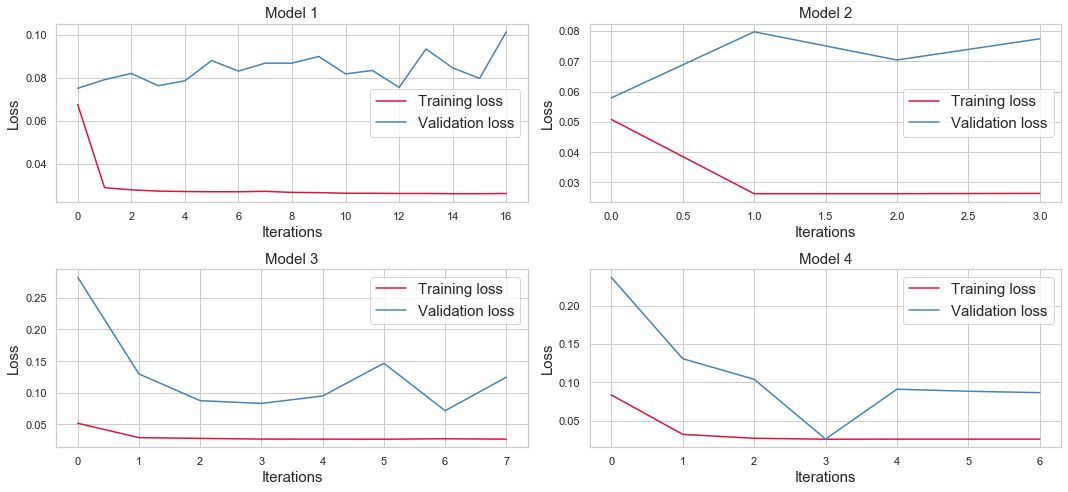

In [124]:
#loss dei mdelli prese dall'output delle prove che abbiamo fatto
loss_model_154 = {'train': [0.0838, 0.0324, 0.0273, 0.0261, 0.0262, 0.0262, 0.0262],
                  'val' : [0.2368, 0.1309, 0.1041, 0.0263, 0.0912, 0.0885, 0.0867]}

loss_model_257 = {'train': [0.0508, 0.0263, 0.0263, 0.0264],
                  'val' : [0.0579, 0.0797, 0.0704, 0.0774]}

loss_model_437 = {'train': [0.0516, 0.0289, 0.0277, 0.0266, 0.0265, 0.0264, 0.0271, 0.0265],
                  'val' : [0.2823, 0.1295, 0.0873, 0.0830, 0.0947, 0.1465, 0.0715, 0.1244]}

loss_model_438 = {'train' : [0.0675, 0.0288, 0.0278, 0.0272, 0.0270, 0.0269, 0.0269, 0.0271, 0.0266, 0.0265, 0.0262, 0.0262 , 0.0261, 0.0261, 0.0260, 0.0260, 0.0261], 
                  'val' : [0.0751, 0.0791, 0.0820, 0.0763, 0.0786, 0.0880, 0.0831, 0.0868, 0.0868, 0.0899, 0.0818, 0.0834, 0.0755, 0.0934, 0.0846, 0.0797, 0.1014]}

f = 15
plt.figure(figsize = (15, 7))
figdims = (2,2)

plt.subplot2grid(figdims, (0, 0))
plt.plot(loss_model_438['train'], color = 'crimson') # underfitting model (model 1)
plt.plot(loss_model_438['val'], color = 'steelblue')
plt.xlabel("Iterations", fontsize = f)
plt.ylabel("Loss", fontsize = f)
plt.legend(['Training loss', 'Validation loss'], fontsize = f)
plt.title("Model 1", fontsize = f)

plt.subplot2grid(figdims, (0, 1))
plt.plot(loss_model_257['train'], color = 'crimson') # model 2
plt.plot(loss_model_257['val'], color = 'steelblue')
plt.xlabel("Iterations", fontsize = f)
plt.ylabel("Loss", fontsize = f)
plt.legend(['Training loss', 'Validation loss'], fontsize = f)
plt.title("Model 2", fontsize = f)

plt.subplot2grid(figdims, (1, 0))
plt.plot(loss_model_437['train'], color = 'crimson') # model 3
plt.plot(loss_model_437['val'], color = 'steelblue')
plt.xlabel("Iterations", fontsize = f)
plt.ylabel("Loss", fontsize = f)
plt.legend(['Training loss', 'Validation loss'], fontsize = f)
plt.title("Model 3", fontsize = f)

plt.subplot2grid(figdims, (1, 1))
plt.plot(loss_model_154['train'], color = 'crimson') # model 4
plt.plot(loss_model_154['val'], color = 'steelblue')
plt.xlabel("Iterations", fontsize = f)
plt.ylabel("Loss", fontsize = f)
plt.legend(['Training loss', 'Validation loss'], fontsize = f)
plt.title("Model 4", fontsize = f)

plt.tight_layout()
plt.show()

Accuracy 0.99594682230869
F1-score [0.9975294 0.9887235]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5071
           1       0.98      1.00      0.99      1097

    accuracy                           1.00      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       1.00      1.00      1.00      6168



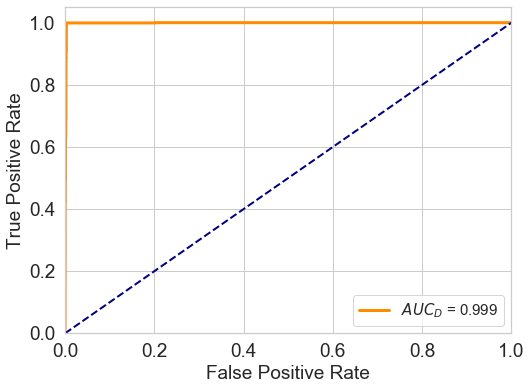

In [153]:
# ROC curve e lift chart di model 3 (per report)

y_pred = model_list[583].predict_classes(X_test)
y_score = model_list[583].predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='$AUC_D$ = %.3f' % (roc_auc))
f=19
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=f)
plt.ylabel('True Positive Rate', fontsize=f)
plt.legend(loc="lower right", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=f)
plt.show()

In [151]:
# salvimo i modelli per porterli riprodurre successivamente
def save_model(model, name):
    # serialize model to JSON
    model_json = model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(name + ".h5")
    print(name, "salvato")
    
save_model(model_list[-1], "Model 1") # -1 è l'indice del modello migliore
save_model(model_list[571], "Model 2")
save_model(model_list[583], "Model 3")
save_model(model_list[581], "Model 4")

Model 1 salvato
Model 2 salvato
Model 3 salvato
Model 4 salvato


In [185]:
# converto y_score in y per renderlo compatibile con plot_cumulative_gain()
y = []
for elem in y_score.ravel():
    l = []
    
    l.append(1-elem)
    l.append(elem)
    
    y.append(l)

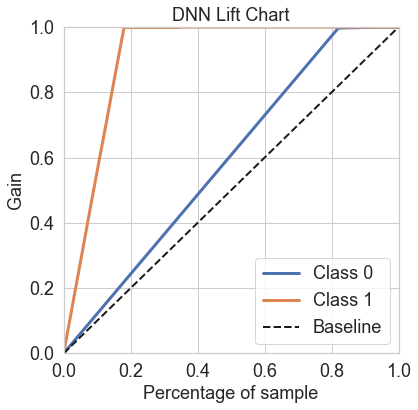

In [187]:
from scikitplot.metrics import plot_cumulative_gain
plot_cumulative_gain(y_test, y, title = 'DNN Lift Chart', figsize = (6,6), title_fontsize = 18, text_fontsize = 18)